Import Library

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import os
import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Preprocessing Data

In [2]:
class gajahsapi(Dataset):

    def __init__(self, root_dir, random_seed=42, image_size=224):

        self.root_dir = root_dir
        self.image_size = image_size

        if not os.path.exists(self.root_dir):
            raise RuntimeError(f"Dataset not found at {self.root_dir}.")

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.data = []
        self.labels = []

        for label, class_name in tqdm(enumerate(['gajah', 'sapi'])):
            class_dir = os.path.join(self.root_dir, class_name)
            image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
            self.data.extend(image_paths)
            self.labels.extend([label] * len(image_paths))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Memasukkan Transfer Learning

In [3]:
batch_size = 32
test_batch_size = 32
train_dataset = gajahsapi(root_dir='/kaggle/input/datasate/dataset/train')
test_dataset  = gajahsapi(root_dir='/kaggle/input/datasate/dataset/test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
num_features = model.classifier[1].in_features
num_classes_output = 2
model.classifier[1] = nn.Linear(in_features=num_features, out_features=num_classes_output)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

2it [00:00, 55.03it/s]
2it [00:00, 58.08it/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


cuda


100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 


In [4]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

Total parameters: 2.23M
Trainable parameters: 2.23M


Training Model

In [5]:
num_epoch = 10
train_losses = []
test_losses = []

for epoch in range(num_epoch):
	model.train()

	train_loss = 0

	for data, labels in tqdm(train_loader):

		data, labels = data.to(device), labels.to(device)
		bs = data.size()[0]
		optimizer.zero_grad()

		outputs = model(data)
		loss = criterion(outputs, labels)

		loss.backward()

		optimizer.step()

		train_loss += loss.item() * data.size(0)

	model.eval()

	correct = 0
	total = 0
	test_loss = 0

	with torch.no_grad():
		for data, labels in tqdm(test_loader):
			data, labels = data.to(device), labels.to(device)
			bs = data.size()[0]
			outputs = model(data)

			loss = criterion(outputs, labels)
			test_loss += loss.item() * data.size(0)

			_, preds = torch.max(outputs, 1)
			correct += (preds == labels).sum().item()

			total += labels.size(0)

	acc = correct / total
	avg_train_loss = train_loss / len(train_dataset)
	avg_test_loss = test_loss / len(test_dataset)

	train_losses.append(avg_train_loss)
	test_losses.append(avg_test_loss)

	print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch 1: Train Loss 0.8494, Test Loss 0.7238, Test Acc 0.4286


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch 2: Train Loss 0.6980, Test Loss 0.7059, Test Acc 0.6190


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


Epoch 3: Train Loss 0.5914, Test Loss 0.6763, Test Acc 0.6667


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Epoch 4: Train Loss 0.4962, Test Loss 0.6313, Test Acc 0.7619


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


Epoch 5: Train Loss 0.4149, Test Loss 0.5729, Test Acc 0.9048


100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


Epoch 6: Train Loss 0.3525, Test Loss 0.5125, Test Acc 0.9048


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


Epoch 7: Train Loss 0.2885, Test Loss 0.4498, Test Acc 1.0000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Epoch 8: Train Loss 0.2346, Test Loss 0.3918, Test Acc 1.0000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


Epoch 9: Train Loss 0.1952, Test Loss 0.3348, Test Acc 1.0000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

Epoch 10: Train Loss 0.1639, Test Loss 0.2877, Test Acc 1.0000


In [6]:
torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'gajah_sapi_checkpoint.pth')

Evaluasi

In [7]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Akurasi pada data uji: {acc:.4f}")

    print("\\nClassification Report:")
    print(classification_report(all_labels, all_preds,labels=[0, 1],  target_names=['gajah', 'sapi']))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['gajah', 'sapi'], yticklabels=['gajah', 'sapi'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Akurasi pada data uji: 1.0000
\nClassification Report:
              precision    recall  f1-score   support

       gajah       1.00      1.00      1.00        21
        sapi       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        21
   macro avg       0.50      0.50      0.50        21
weighted avg       1.00      1.00      1.00        21



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

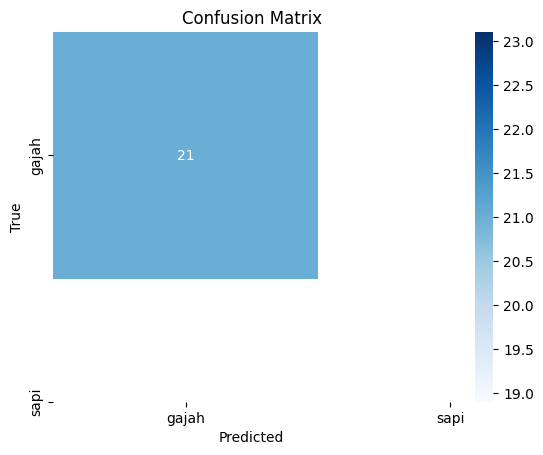

In [8]:
evaluate_model(model, test_loader, device)

Visualisasi

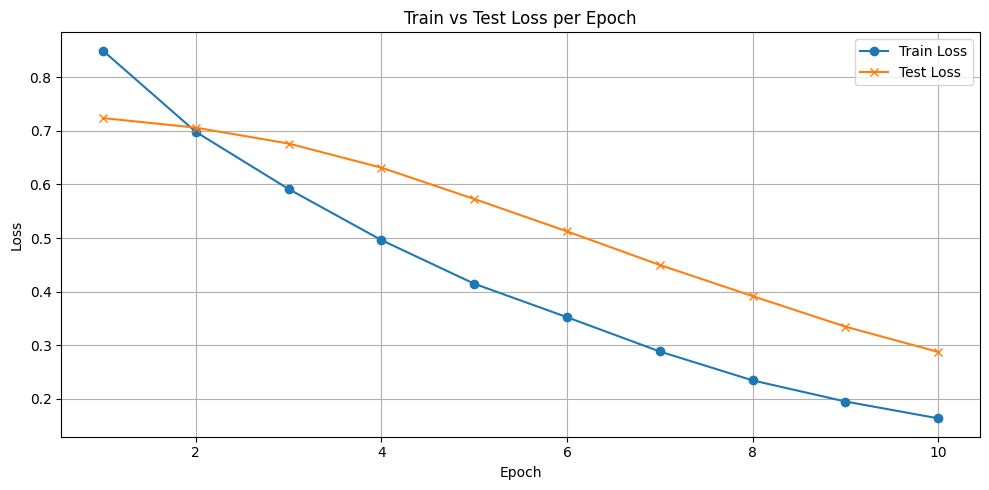

In [9]:
epochs = range(1, num_epoch + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
def load_model(weight_path, num_classes, device):
    checkpoint = torch.load(weight_path, map_location=device)

    model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model

In [11]:
def predict_image(image_path, model, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = class_names[pred.item()]
    return predicted_class, image

Testing

Prediction: gajah


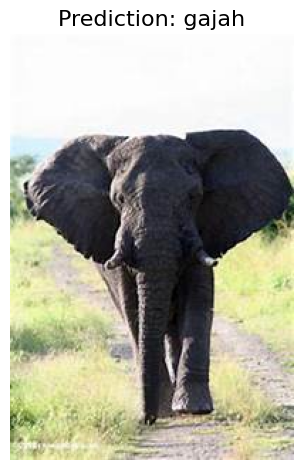

In [12]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['gajah', 'sapi']

    model = load_model('gajah_sapi_checkpoint.pth', num_classes=len(class_names), device=device)

    img_path = '/kaggle/input/gajah-and-sapi/GAJAH.jpeg'
    predicted_label, image = predict_image(img_path, model, device, class_names)

    print(f"Prediction: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()

Prediction: sapi


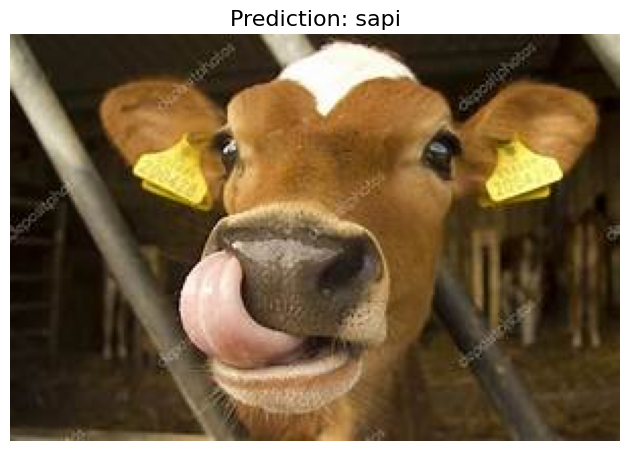

In [14]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Gantilah dengan label sesuai urutan di dataset ImageFolder
    class_names = ['sapi', 'gajah']

    # Load model
    model = load_model('gajah_sapi_checkpoint.pth', num_classes=len(class_names), device=device)

    # Ganti path gambar sesuai kebutuhan
    img_path = '/kaggle/input/gajah-and-sapi/SAPI.jpeg'
    predicted_label, image = predict_image(img_path, model, device, class_names)

    print(f"Prediction: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()